# Worksheet 22

Name: Eric Wang

UID: U21489105

### Topics

- Gradient Descent

## Gradient Descent

Recall in Linear Regression we are trying to find the line $$y = X \beta$$ that minimizes the sum of square distances between the predicted `y` and the `y` we observed in our dataset:

$$\mathcal{L}(\mathbf{\beta}) = \Vert \mathbf{y} - X\mathbf{\beta} \Vert^2$$

We were able to find a global minimum to this loss function but we will try to apply gradient descent to find that same solution.

a) Implement the `loss` function to complete the code and plot the loss as a function of beta.

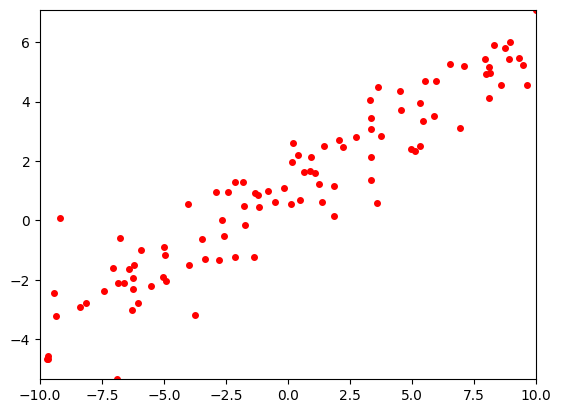

In [3]:
# %matplotlib widget
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

beta = np.array([ 1 , .5 ])
xlin = -10.0 + 20.0 * np.random.random(100)
X = np.column_stack([np.ones((len(xlin), 1)), xlin])
y = beta[0]+(beta[1]*xlin)+np.random.randn(100)

fig, ax = plt.subplots()
ax.plot(xlin, y,'ro',markersize=4)
ax.set_xlim(-10, 10)
ax.set_ylim(min(y), max(y))
plt.show()

In [ ]:
b0 = np.arange(-5, 4, 0.1)
b1 = np.arange(-5, 4, 0.1)
b0, b1 = np.meshgrid(b0, b1)

def loss(X, y, beta):
    return ...

def get_cost(B0, B1):
    res = []
    for b0, b1 in zip(B0, B1):
        line = []
        for i in range(len(b0)):
            beta = np.array([b0[i], b1[i]])
            line.append(loss(X, y, beta))
        res.append(line)
    return np.array(res)

cost = get_cost(b0, b1)
 
# Creating figure
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')
ax.set_xlim(-6, 4)
ax.set_xlabel(r'$\beta_0$')
ax.set_ylabel(r'$\beta_1$')
ax.set_ylim(-5, 4)
ax.set_zlim(0, 30000)

# Creating plot
ax.plot_surface(b0, b1, cost, alpha=.7)
 
# show plot
plt.show()

Since the loss is

$$\mathcal{L}(\mathbf{\beta}) = \Vert \mathbf{y} - X\mathbf{\beta} \Vert^2 = \beta^T X^T X \beta - 2\mathbf{\beta}^TX^T\mathbf{y}  + \mathbf{y}^T\mathbf{y}$$

The gradient is

$$\nabla_\beta \mathcal{L}(\mathbf{\beta}) = 2X^T X \beta - 2X^T\mathbf{y}$$

b) Implement the gradient function below and complete the gradient descent algorithm

In [39]:
import numpy as np
from PIL import Image as im
import matplotlib.pyplot as plt

TEMPFILE = "temp.png"

def snap(betas, losses):
    # Creating figure
    fig = plt.figure(figsize =(14, 9))
    ax = plt.axes(projection ='3d')
    ax.view_init(20, -20)
    ax.set_xlim(-5, 4)
    ax.set_xlabel(r'$\beta_0$')
    ax.set_ylabel(r'$\beta_1$')
    ax.set_ylim(-5, 4)
    ax.set_zlim(0, 30000)

    # Creating plot
    ax.plot_surface(b0, b1, cost, color='b', alpha=.7)
    ax.plot(np.array(betas)[:,0], np.array(betas)[:,1], losses, 'o-', c='r', markersize=10, zorder=10)
    fig.savefig(TEMPFILE)
    plt.close()
    return im.fromarray(np.asarray(im.open(TEMPFILE)))


def gradient(X, y, beta):
    return ...


def gradient_descent(X, y, beta_hat, learning_rate, epochs, images):
    losses = [loss(X, y, beta_hat)]
    betas = [beta_hat]

    for _ in range(epochs):
        images.append(snap(betas, losses))
        beta_hat = ...

        losses.append(loss(X, y, beta_hat))
        betas.append(beta_hat)
        
    return np.array(betas), np.array(losses)


beta_start = np.array([-5, -2])
learning_rate = 0.0002 # try .0005
images = []
betas, losses = gradient_descent(X, y, beta_start, learning_rate, 10, images)

images[0].save(
    'gd.gif',
    optimize=False,
    save_all=True,
    append_images=images[1:],
    loop=0,
    duration=500
)

c) Use the code above to create an animation of the linear model learned at every epoch.

In [44]:
def snap_model(beta):
    xplot = np.linspace(-10,10,50)
    yestplot = ...
    fig, ax = plt.subplots()
    ax.plot(xplot, yestplot,'b-',lw=2)
    ax.plot(xlin, y,'ro',markersize=4)
    ax.set_xlim(-10, 10)
    ax.set_ylim(min(y), max(y))
    fig.savefig(TEMPFILE)
    plt.close()
    return im.fromarray(np.asarray(im.open(TEMPFILE)))


def gradient_descent(X, y, beta_hat, learning_rate, epochs, images):
    losses = [loss(X, y, beta_hat)]
    betas = [beta_hat]

    for _ in range(epochs):
        images.append(...)
        beta_hat = beta_hat - learning_rate * gradient(X, y, beta_hat)

        losses.append(loss(X, y, beta_hat))
        betas.append(beta_hat)
        
    return np.array(betas), np.array(losses)


images = []
betas, losses = gradient_descent(X, y, beta_start, learning_rate, 100, images)

images[0].save(
    'model.gif',
    optimize=False,
    save_all=True,
    append_images=images[1:],
    loop=0,
    duration=200
)

In logistic regression, the `loss` is the negative log-likelihood

$$ \mathcal{l}(\mathbf{\beta}) = - \frac{1}{N} \sum_{i=1}^{N} y_i \log(\sigma(x_i \beta)) + (1 - y_i)\log(1 - \sigma(x_i \beta))$$

the gradient of which is:

$$\nabla_\beta \mathcal{l}(\mathbf{\beta}) = \frac{1}{N} \sum_{i=1}^{N} x_i (y_i - \sigma(x_i \beta)) $$

d) Plot the loss as a function of b.

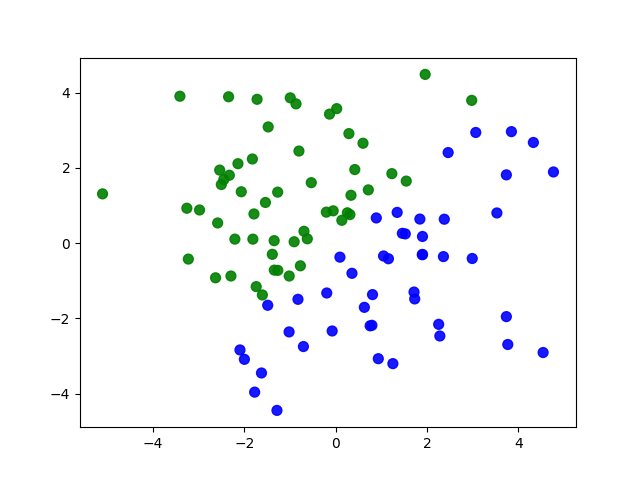

In [6]:
%matplotlib widget
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

centers = [[0, 0]]
t, _ = datasets.make_blobs(n_samples=100, centers=centers, cluster_std=2, random_state=0)

# LINE
def generate_line_data():
    # create some space between the classes
    X = t
    Y = np.array([1 if x[0] - x[1] >= 0 else 0 for x in X])
    return X, Y

X, y = generate_line_data()

cs = np.array([x for x in 'gb'])
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], color=cs[y].tolist(), s=50, alpha=0.9)
plt.show()

In [ ]:
b0 = np.arange(-20, 20, 0.1)
b1 = np.arange(-20, 20, 0.1)
b0, b1 = np.meshgrid(b0, b1)


def sigmoid(x):
    e = np.exp(x)
    return e / (1 + e)


def loss(X, y, beta):
    ...


def get_cost(B0, B1):
    res = []
    for b0, b1 in zip(B0, B1):
        line = []
        for i in range(len(b0)):
            beta = np.array([b0[i], b1[i]])
            line.append(loss(X, y, beta))
        res.append(line)
    return np.array(res)

cost = get_cost(b0, b1)

# Creating figure
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')
ax.set_xlim(-20, 20)
ax.set_xlabel(r'$\beta_0$')
ax.set_ylabel(r'$\beta_1$')
ax.set_ylim(-20, 20)
ax.set_zlim(0, 10)

# Creating plot
ax.plot_surface(b0, b1, cost, alpha=.7)
 
# show plot
plt.show()

e) Plot the loss at each iteration of the gradient descent algorithm.

In [22]:
import numpy as np
from PIL import Image as im
import matplotlib.pyplot as plt

TEMPFILE = "temp.png"

def snap(betas, losses):
    # Creating figure
    fig = plt.figure(figsize =(14, 9))
    ax = plt.axes(projection ='3d')
    ax.view_init(10, 10)
    ax.set_xlabel(r'$\beta_0$')
    ax.set_ylabel(r'$\beta_1$')
    ax.set_ylim(-20, 20)
    ax.set_zlim(0, 10)

    # Creating plot
    ax.plot_surface(b0, b1, cost, color='b', alpha=.7)
    ax.plot(np.array(betas)[:,0], np.array(betas)[:,1], losses, 'o-', c='r', markersize=10, zorder=10)
    fig.savefig(TEMPFILE)
    plt.close()
    return im.fromarray(np.asarray(im.open(TEMPFILE)))


def gradient(X, y, beta):
    return ...


def gradient_descent(X, y, beta_hat, learning_rate, epochs, images):
    losses = [loss(X, y, beta_hat)]
    betas = [beta_hat]

    for _ in range(epochs):
        images.append(snap(betas, losses))
        beta_hat = beta_hat - learning_rate * gradient(X, y, beta_hat)

        losses.append(loss(X, y, beta_hat))
        betas.append(beta_hat)
        
    return np.array(betas), np.array(losses)


beta_start = np.array([-5, -2])
learning_rate = 0.1
images = []
betas, losses = gradient_descent(X, y, beta_start, learning_rate, 10, images)

images[0].save(
    'gd_logit.gif',
    optimize=False,
    save_all=True,
    append_images=images[1:],
    loop=0,
    duration=500
)

f) Create an animation of the logistic regression fit at every epoch.

g) Modify the above code to evaluate the gradient on a random batch of the data. Overlay the true loss curve and the approximation of the loss in your animation.

h) Below is a sandox where you can get intuition about how to tune gradient descent parameters:

In [12]:
import numpy as np
from PIL import Image as im
import matplotlib.pyplot as plt

TEMPFILE = "temp.png"

def snap(x, y, pts, losses, grad):
    fig = plt.figure(figsize =(14, 9))
    ax = plt.axes(projection ='3d')
    ax.view_init(20, -20)
    ax.plot_surface(x, y, loss(np.array([x, y])), color='r', alpha=.4)
    ax.plot(np.array(pts)[:,0], np.array(pts)[:,1], losses, 'o-', c='b', markersize=10, zorder=10)
    ax.plot(np.array(pts)[-1,0], np.array(pts)[-1,1], -1, 'o-', c='b', alpha=.5, markersize=7, zorder=10)
    
    # Plot Gradient Vector
    X, Y, Z = [pts[-1][0]], [pts[-1][1]], [-1]
    U, V, W = [-grad[0]], [-grad[1]], [0]
    ax.quiver(X, Y, Z, U, V, W, color='g')
    fig.savefig(TEMPFILE)
    plt.close()
    return im.fromarray(np.asarray(im.open(TEMPFILE)))

def loss(x):
    return np.sin(sum(x**2)) # change this

def gradient(x):
    return 2 * x * np.cos(sum(x**2)) # change this

def gradient_descent(x, y, init, learning_rate, epochs):
    images, losses, pts = [], [loss(init)], [init]
    for _ in range(epochs):
        grad = gradient(init)
        images.append(snap(x, y, pts, losses, grad))
        init = init - learning_rate * grad
        losses.append(loss(init))
        pts.append(init)
    return images

init = np.array([-.5, -.5]) # change this
learning_rate = 1.394 # change this
x, y = np.meshgrid(np.arange(-2, 2, 0.1), np.arange(-2, 2, 0.1)) # change this
images = gradient_descent(x, y, init, learning_rate, 12)

images[0].save(
    'gradient_descent.gif',
    optimize=False,
    save_all=True,
    append_images=images[1:],
    loop=0,
    duration=500
)